# Clinical application of connectome kernel normative models

---

Using the connectome spectral normative models developed in notebooks in chapter 5, we now turn our attention to applying the pretrained spectral model to a clinical sample to extract interesting knowledge about how pathological brain changes are linked to behaviors.

Note: this notebook is executed on CSC servers...

## Notebook 7.1.2: MACC Model tuning

### package imports and basic functions

---

In [1]:
import os
import gc
import sys
import glob
import json
import random
import datetime
import importlib
import itertools
import numpy as np
from scipy import spatial
import scipy.sparse as sparse
import scipy.stats as stats
import pandas as pd
import nibabel as nib
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import boto3
from tqdm.notebook import tqdm
from sklearn import metrics


In [2]:
# pymc libraries
import pymc as pm
import arviz as az
import xarray as xr
import patsy

print(f"Running on PyMC v{pm.__version__}")


Running on PyMC v4.2.2


In [3]:
class MyNumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        else:
            return super(MyEncoder, self).default(obj)


def ensure_dir(file_name):
    os.makedirs(os.path.dirname(file_name), exist_ok=True)
    return file_name


def list_dirs(path=os.getcwd()):
    files = glob.glob(os.path.join(path, '*'))
    files = [x for x in files if os.path.isdir(x)]
    return files


def file_exists(file_name, path_name=os.getcwd()):
    return os.path.isfile(os.path.join(path_name, file_name))


def write_json(json_obj, file_path):
    with open(file_path, 'w') as outfile:
        json.dump(json_obj, outfile, sort_keys=True, indent=4,
                  cls=MyNumpyEncoder)
    return json_obj


def load_json(file_path):
    with open(file_path, 'r') as infile:
        return json.load(infile)


def write_np(np_obj, file_path):
    with open(file_path, 'wb') as outfile:
        np.save(outfile, np_obj)


def load_np(file_path):
    with open(file_path, 'rb') as infile:
        return np.load(infile)


In [4]:
# path setting
main_dir = "/home/sina/storage"
gitrepo_dir = f"{main_dir}/Normative_Modeling/git-repo/normative_brain_charts"
# clone of https://github.com/Washington-University/HCPpipelines
hcp_pipeline_dir = f"{main_dir}/HCPpipelines"
# clone of https://github.com/edickie/ciftify
ciftify_dir = f"{main_dir}/ciftify"


### Brain visualization functions

---

In [5]:
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Computer Modern']


In [6]:
# basic parameters
surface = 'inflated_MSMAll'
expand = 0

# load an example dscalar
dscalar_file = f'{hcp_pipeline_dir}/global/templates/91282_Greyordinates/91282_Greyordinates.dscalar.nii'
dscalar = nib.load(dscalar_file)

brain_models = [x for x in dscalar.header.get_index_map(1).brain_models]

# load surfaces for visualization
# left_surface_file = f'{main_dir}/data/templates/hcp_surf/S1200.L.{surface}.32k_fs_LR.surf.gii'
left_surface_file = f'{ciftify_dir}/ciftify/data/HCP_S1200_GroupAvg_v1/S1200.L.{surface}.32k_fs_LR.surf.gii'
left_surface = nib.load(left_surface_file)
right_surface_file = f'{ciftify_dir}/ciftify/data/HCP_S1200_GroupAvg_v1/S1200.R.{surface}.32k_fs_LR.surf.gii'
right_surface = nib.load(right_surface_file)

# extract surface information
lx, ly, lz = left_surface.darrays[0].data.T
lt = left_surface.darrays[1].data
rx, ry, rz = right_surface.darrays[0].data.T
rt = right_surface.darrays[1].data

# combine into a complete brain
lrx = np.concatenate([lx - expand, rx + expand])
lry = np.concatenate([ly, ry])
lrz = np.concatenate([lz, rz])
lrt = np.concatenate([lt, (rt + lx.shape[0])])

lxyz = left_surface.darrays[0].data
rxyz = right_surface.darrays[0].data
lrxyz = np.array([lrx, lry, lrz]).T

# create a mapping between surface and cifti vertices
left_cortical_surface_model, right_cortical_surface_model = brain_models[0], brain_models[1]
cifti_to_surface = {}
surface_to_cifti = {}
for (i, x) in enumerate(left_cortical_surface_model.vertex_indices):
    cifti_to_surface[i] = x
    surface_to_cifti[x] = i
for (i, x) in enumerate(right_cortical_surface_model.vertex_indices):
    cifti_to_surface[i + right_cortical_surface_model.index_offset] = x + rx.shape[0]
    surface_to_cifti[x + rx.shape[0]] = i + right_cortical_surface_model.index_offset

# construct data over surface
surface_mask = list(surface_to_cifti.keys())


#### Faster brain visualization by Cerebro

---

In [7]:
# Cerebro brain viewer used for visualization
from cerebro import cerebro_brain_utils as cbu
from cerebro import cerebro_brain_viewer as cbv


In [8]:
# Brain visualizations with Cerebro

# ignore warning when loading cifti
nib.imageglobals.logger.setLevel(40)

from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.gridspec import GridSpec

def plot_single_view_with_cerebro(dscalar_data, ax, colormap=plt.cm.coolwarm, clims=None, vlims=None, exclusion_color=(1.,1.,1.,0), view="L", show_colorbar=False, colorbar_format=None, cifti_left_right_seperation=0, surface = 'midthickness'):
    try:
        
        my_brain_viewer = cbv.Cerebro_brain_viewer(offscreen=True, background_color=(1.,1.,1.,0), null_color=(1., 1., 1., 0.0), no_color=(0.7, 0.7, 0.7, 1.))

        surface_model = my_brain_viewer.load_template_GIFTI_cortical_surface_models(surface)

        cifti_space = my_brain_viewer.visualize_cifti_space(
            volumetric_structures='none', cifti_left_right_seperation=cifti_left_right_seperation,
        )

        dscalar_layer = my_brain_viewer.add_cifti_dscalar_layer(
            dscalar_data=dscalar_data,
            colormap=colormap,
            clims=clims,
            vlims=vlims,
            exclusion_color=exclusion_color,
            opacity=0.95)

        ax.axis('off')
        camconf = my_brain_viewer._view_to_camera_config(view)
        # camconf = my_brain_viewer.zoom_camera_to_content(camconf)
        my_brain_viewer.viewer.change_view(**camconf)
        my_brain_viewer.offscreen_draw_to_matplotlib_axes(ax)

    finally:
        my_brain_viewer.viewer.window.destroy()

def plot_left_right_surface_with_cerebro(dscalar_data, ax, colormap=plt.cm.coolwarm, clims=None, show_colorbar=False, colorbar_format=None, **kwargs):
    # Hide the parent axis
    ax.set_visible(False)

    # Create a 2x2 GridSpec within the axis using inset_axes
    gs = ax.inset_axes([0, 0, 1, 1], transform=ax.transAxes)
    sub_gs = GridSpec(2, 2, gs, hspace=0., wspace=0.)

    # Create a 4x4 grid
    ax_tl = fig.add_subplot(sub_gs[0, 0])
    ax_tr = fig.add_subplot(sub_gs[0, 1])
    ax_bl = fig.add_subplot(sub_gs[1, 0])
    ax_br = fig.add_subplot(sub_gs[1, 1])
    
    # separate data to left and right
    dscalar_data_left = dscalar_data.copy()
    dscalar_data_left[left_cortical_surface_model.index_count:] = np.nan
    dscalar_data_right = dscalar_data.copy()
    dscalar_data_right[:left_cortical_surface_model.index_count] = np.nan
    
    # Lateral left view
    plot_single_view_with_cerebro(dscalar_data_left, ax_tl, colormap=colormap, clims=clims,
                                  view=((-420, 0, 0), None, None, None), **kwargs)
    # Medial left view
    plot_single_view_with_cerebro(dscalar_data_left, ax_bl, colormap=colormap, clims=clims,
                                  view=((420, 0, 0), None, None, None), cifti_left_right_seperation=-80, **kwargs)
    
    # Lateral right view
    plot_single_view_with_cerebro(dscalar_data_right, ax_tr, colormap=colormap, clims=clims,
                                  view=((420, 0, 0), None, None, None), **kwargs)
    # Medial right view
    plot_single_view_with_cerebro(dscalar_data_right, ax_br, colormap=colormap, clims=clims,
                                  view=((-420, 0, 0), None, None, None), cifti_left_right_seperation=-80, **kwargs)

    if show_colorbar:
        cax = inset_axes(
            ax,
            width="30%",
            height="4%",
            loc="center",
            bbox_to_anchor=(-0., 0.0, 1., 1.),
            bbox_transform=ax.transAxes,
            borderpad=0,
        )
        cb = fig.colorbar(
            mpl.cm.ScalarMappable(
                norm=mpl.colors.Normalize(vmin=clims[0], vmax=clims[1]),
                cmap=colormap
            ),
            cax=cax,
            aspect=10,
            orientation='horizontal',
            format=colorbar_format,
        )
        cb.outline.set_visible(False)
        cb.ax.tick_params(labelsize=12)
        cb.ax.tick_params(length=0)


## Load the connectome kernel

---

In [9]:
# load the connectivity eigenmodes
N_kernels = 1000
connectome_kernel_eigenvalues = load_np(f'{main_dir}/Normative_Modeling/data/npy/rw_cortical_connectome_eigenvalues_cifti.npy')[:N_kernels];
connectome_kernel_eigenvectors = load_np(f'{main_dir}/Normative_Modeling/data/npy/rw_cortical_connectome_eigenvectors_cifti.npy')[:,:N_kernels];


## Create a fixed BSpline function to ensure consistent nonlinear expansions of age across all models

---



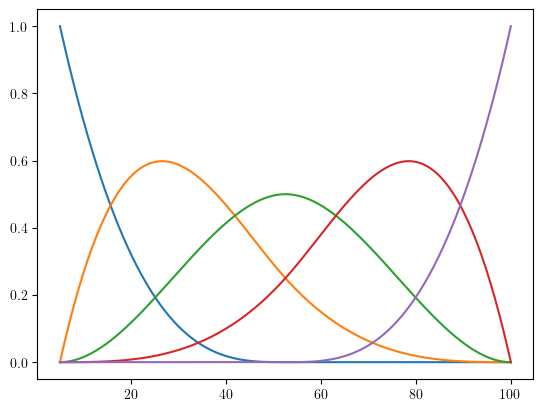

In [10]:
# fixed B-spline
age_min=5
age_max=100
num_knots = 3
patsy_knots = np.linspace(age_min, age_max, num_knots)[1:-1]
fixed_B_spline_age = patsy.dmatrix(
    "bs(xi, knots=knots, degree=3, include_intercept=True) - 1",
    {"xi": (np.linspace(age_min, age_max, 200)), "knots": patsy_knots},
)
plt.plot(np.linspace(age_min, age_max, 200), fixed_B_spline_age)



## Load selected covariance pairs

---

The largest pairs of kernels in terms of correlation are stored to model a sparse covariance structure.


In [11]:
corr_max_all = load_np(f'{main_dir}/Normative_Modeling/data/models/pymc/connectome_rw_kernel_rho_corr_max_all.npy')
selected_pairs = load_np(f'{main_dir}/Normative_Modeling/data/models/pymc/connectome_rw_kernel_rho_selected_pairs_rho.npy')


In [12]:
rows, cols = np.where(corr_max_all>0.25)
rows_lim = rows[rows < cols]
cols_lim = cols[rows < cols]


In [13]:
len(selected_pairs)

4261

In [14]:
len(rows_lim)

4261

In [15]:
%%time
sparse_filler = sparse.coo_matrix(
    (np.ones(selected_pairs.shape[0]), (selected_pairs[:, 0], selected_pairs[:, 1])),
    shape=(selected_pairs.max() + 1, selected_pairs.max() + 1)
)


CPU times: user 1.51 ms, sys: 733 μs, total: 2.25 ms
Wall time: 1.57 ms


## Load fitted kernel normative models

---


In [16]:
%%time
kernel_posterior_means = xr.open_dataset(f'{main_dir}/Normative_Modeling/data/models/pymc/combined_connectome_rw_kernel_posterior_means_pymc_advi.nc',)
kernel_posterior_means


CPU times: user 197 ms, sys: 41.5 ms, total: 238 ms
Wall time: 699 ms


<xarray.Dataset> Size: 2MB
Dimensions:                (kernel: 10000, sex: 2, site: 3, splines: 5)
Coordinates:
  * sex                    (sex) float64 16B 1.0 0.0
  * site                   (site) <U13 156B 'HCP-YA-site_0' ... 'HCP-A-site_0'
  * splines                (splines) int64 40B 0 1 2 3 4
Dimensions without coordinates: kernel
Data variables:
    mu_intercept_site      (kernel) float64 80kB ...
    intercept_sex          (kernel, sex) float64 160kB ...
    intercept_site_offset  (kernel, site) float64 240kB ...
    w_age                  (kernel, splines) float64 400kB ...
    sigma_intercept_site   (kernel) float64 80kB ...
    sigma_error_site       (kernel) float64 80kB ...
    w_error_age            (kernel, splines) float64 400kB ...
    error_sex              (kernel, sex) float64 160kB ...
    error_site_offset      (kernel, site) float64 240kB ...
    intercept_site         (kernel, site) float64 240kB ...
    error_site             (kernel, site) float64 240kB ...

In [17]:
%%time
rho_kernel_posterior_means = xr.open_dataset(f'{main_dir}/Normative_Modeling/data/models/pymc/combined_connectome_rw_rho_kernel_posterior_means_pymc_advi.nc')
rho_kernel_posterior_means


CPU times: user 64 ms, sys: 5.92 ms, total: 70 ms
Wall time: 131 ms


<xarray.Dataset> Size: 512kB
Dimensions:                    (kernel_pair: 4261, sex: 2, site: 3, splines: 5)
Coordinates:
  * sex                        (sex) float64 16B 1.0 0.0
  * site                       (site) <U13 156B 'HCP-YA-site_0' ... 'HCP-A-si...
  * splines                    (splines) int64 40B 0 1 2 3 4
Dimensions without coordinates: kernel_pair
Data variables:
    mu_intercept_site_rho      (kernel_pair) float64 34kB ...
    intercept_sex_rho          (kernel_pair, sex) float64 68kB ...
    intercept_site_offset_rho  (kernel_pair, site) float64 102kB ...
    w_age_rho                  (kernel_pair, splines) float64 170kB ...
    sigma_intercept_site_rho   (kernel_pair) float64 34kB ...
    intercept_site_rho         (kernel_pair, site) float64 102kB ...

### Also Load observed training moments (mean and sigma used for standardization)

---


In [18]:
%%time
kernel_means = np.load(f'{main_dir}/Normative_Modeling/data/models/pymc/connectome_rw_kernel_kernel_means.npy')[:N_kernels].tolist()
kernel_stds = np.load(f'{main_dir}/Normative_Modeling/data/models/pymc/connectome_rw_kernel_kernel_stds.npy')[:N_kernels].tolist()


CPU times: user 1.94 ms, sys: 1.73 ms, total: 3.67 ms
Wall time: 11.8 ms


In [19]:
len(kernel_means), len(kernel_stds)

(1000, 1000)

## Load all MACC data

---

In [20]:
all_thickness_data_MACC = load_np(f'{main_dir}/Normative_Modeling/data/MACC/summary/cleaned_all_thickness_data_MACC.npy');
all_thickness_data_MACC.shape


(674, 59412)

In [21]:
all_thickness_data_MACC_encoded = load_np(f'{main_dir}/Normative_Modeling/data/MACC/summary/cleaned_all_thickness_data_MACC_encoded.npy');
all_thickness_data_MACC_encoded.shape


(674, 11001)

In [23]:
demography_extended_df_MACC = pd.read_csv(f'{main_dir}/Normative_Modeling/data/MACC/summary/demography_extended_df_MACC.csv')
demography_extended_df_MACC

,subject_ID,sex,age,diagnosis,mmse,thickness_connectome_pc_0,thickness_connectome_pc_1,thickness_connectome_pc_2,thickness_connectome_pc_3,thickness_connectome_pc_4,...,thickness_connectome_pc_992,thickness_connectome_pc_993,thickness_connectome_pc_994,thickness_connectome_pc_995,thickness_connectome_pc_996,thickness_connectome_pc_997,thickness_connectome_pc_998,thickness_connectome_pc_999,age_bins,split
0,HD001,0,58.000000,NCI,26.0,595.404921,-2.988673,28.387228,-47.514605,14.128553,...,2.305832,2.339347,-1.838847,-1.355246,0.406034,1.422772,1.133603,-3.565102,0,Train
1,HD002,1,63.000000,NCI,30.0,578.305361,4.541116,17.579084,-56.689357,15.704129,...,0.006548,-0.752449,1.522519,-0.164277,2.750056,0.936918,-1.015317,0.239366,1,Test
2,HD003,1,87.000000,AD,17.0,583.584819,-3.577608,21.320147,-29.771606,3.478685,...,-0.513072,-0.878510,1.467293,-0.041904,4.759097,-0.118015,-1.831489,1.210456,9,Test
3,HD004,0,72.000000,VCIND,27.0,569.606960,17.875988,33.168828,-21.237119,19.472234,...,2.489475,-0.491276,-4.140618,0.997443,2.554370,-0.693051,-1.779164,-3.283816,3,Test
4,HD005,0,64.000000,VAD,14.0,553.304157,-0.889549,18.389647,-31.733231,4.780241,...,0.988722,0.332366,-0.161542,0.535014,0.762446,-2.808122,2.394301,0.114801,1,Test
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
669,HD708,1,68.000000,CIND,25.0,566.541171,-3.745172,17.742118,-41.644337,13.038910,...,3.311674,1.734526,0.424161,-2.697676,4.151448,1.480859,0.667881,-1.947132,2,Test
670,HD709,0,73.394521,NCI,28.0,574.221681,-7.783637,22.753400,-36.585811,12.150714,...,0.372612,0.954771,2.422085,0.484439,-0.070413,0.852638,0.977014,-2.924204,4,Test
671,HD710,1,73.421918,CIND,29.0,551.158037,2.254310,9.483589,-32.421152,4.467115,...,-0.658736,1.567999,0.683723,-0.107798,1.236113,-1.432196,0.763503,-3.626161,4,Test
672,HD711,1,61.331507,NCI,30.0,597.881738,1.841696,15.793990,-49.422621,10.084503,...,-1.408109,-0.204344,-0.604761,-0.094463,2.077290,-0.483792,0.731981,-4.178934,0,Train


<Axes: xlabel='age', ylabel='thickness_connectome_pc_0'>

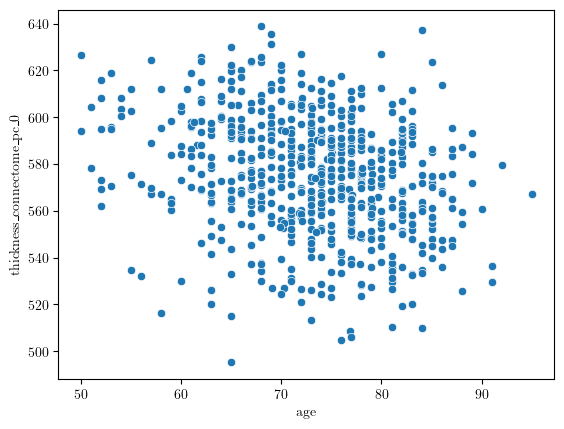

In [28]:
sns.scatterplot(data=demography_extended_df_MACC, x='age', y='thickness_connectome_pc_0')


## Adjust model's site parameters on MACC

---

Using the pretrained model weights, the site parameters are estimated for the new site (MACC) that was not part of the training data.

For this purpose, only a subset (50%) of healthy individuals from MACC were used ($N=66$). The rest of MACC data was left aside for evaluation of the impact of atrophy on individual cognitive decline.

In [32]:
# separate the training sample
train_set =  (demography_extended_df_MACC['split'] == "Train")
train_df = demography_extended_df_MACC[train_set]
train_df


,subject_ID,sex,age,diagnosis,mmse,thickness_connectome_pc_0,thickness_connectome_pc_1,thickness_connectome_pc_2,thickness_connectome_pc_3,thickness_connectome_pc_4,...,thickness_connectome_pc_992,thickness_connectome_pc_993,thickness_connectome_pc_994,thickness_connectome_pc_995,thickness_connectome_pc_996,thickness_connectome_pc_997,thickness_connectome_pc_998,thickness_connectome_pc_999,age_bins,split
0,HD001,0,58.000000,NCI,26.0,595.404921,-2.988673,28.387228,-47.514605,14.128553,...,2.305832,2.339347,-1.838847,-1.355246,0.406034,1.422772,1.133603,-3.565102,0,Train
16,HD017,1,64.000000,NCI,27.0,616.386438,-3.728981,26.329888,-47.000315,8.603586,...,-0.673742,-0.413588,-0.596424,0.482613,2.143149,2.940887,-1.249855,-1.152129,1,Train
17,HD018,0,60.000000,NCI,25.0,604.480539,-0.877740,15.977705,-63.095665,13.330561,...,-2.424815,1.629643,-1.043369,-2.554234,0.553980,-3.483845,0.502065,-0.857705,0,Train
45,HD046,0,80.000000,NCI,28.0,573.999180,1.940235,15.625362,-44.464568,11.114549,...,-1.289964,1.496811,1.129301,-2.652221,0.472992,-2.489786,-1.434465,-4.673961,7,Train
56,HD057,1,65.000000,NCI,29.0,594.807776,-0.492106,17.277696,-51.797485,12.668014,...,-0.253051,1.303837,2.010774,0.223030,2.078337,0.541294,0.120345,-1.116903,1,Train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
663,HD702,1,55.000000,NCI,27.0,612.008720,-1.714372,25.824236,-51.308783,11.888427,...,-0.138495,-1.406280,-2.289884,0.969469,2.238522,1.869043,0.027165,-1.699167,0,Train
664,HD703,1,57.000000,NCI,27.0,624.293576,-6.717786,21.639560,-48.899159,15.707542,...,-0.507085,1.432430,-0.711302,-1.804139,1.562492,3.271574,-1.047298,-2.286399,0,Train
666,HD705,1,51.000000,NCI,29.0,604.303297,1.311674,22.754947,-54.188499,15.821709,...,1.939418,-0.214855,-0.696480,2.598492,1.587336,1.246330,0.618949,-3.773863,0,Train
668,HD707,1,65.000000,NCI,30.0,615.271586,1.273680,14.859131,-48.493335,10.410601,...,0.410259,1.063633,-2.076568,-3.307968,2.509897,-0.512804,-1.589560,-2.185951,1,Train


In [45]:
# Note: originally trained model had a flip of sex values in factorize, this should be enforced when applying to new sample
sex_idxs, sexes = pd.factorize(train_df['sex'])
1 - sex_idxs, 1 - sexes, train_df['sex']


(array([1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0,
        1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0,
        0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0]),
 Index([1, 0], dtype='int64'),
 0      0
 16     1
 17     0
 45     0
 56     1
       ..
 663    1
 664    1
 666    1
 668    1
 672    1
 Name: sex, Length: 66, dtype: int64)

In [58]:
# Note: originally trained model had a flip of sex values in factorize, this should be enforced when applying to new sample
site_idxs, sites = pd.factorize(train_df['sex']*0)
site_idxs, sites

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 Index([0], dtype='int64'))

### Run parallel models to fine-tune normative distributions for every kernel (site parameters)

---

In [74]:
# random seed for reproducibility
rng = np.random.default_rng(12345)

def fine_tune_pymc_advi_on_kernel_for_MACC(kernel_idx, train_df=train_df, fixed_B_spline_age=fixed_B_spline_age):
    kernel_name = f'thickness_connectome_pc_{kernel_idx}'
    # sample from required columns
    sample_df = train_df[['age', 'sex', kernel_name]].copy()

    # Data preperation
    age = sample_df['age'].values
    thickness = sample_df[kernel_name].values
    thickness_standardized = (thickness - kernel_means[kernel_idx]) / kernel_stds[kernel_idx]

    # dummy site variable of only one dimension
    site_idxs, sites = pd.factorize(train_df['sex']*0)

    # sex variable
    sex_idxs, sexes = pd.factorize(sample_df['sex'])
    # adjust for the original model flipping
    sex_idxs, sexes = (1 - sex_idxs), (1 - sexes)
    
    # Splines to model nonlinear age effects on thickness
    # Using the fixed B-Spline, no need to standardize age range
    B_spline_age = patsy.build_design_matrices(
        [fixed_B_spline_age.design_info],
        {"xi": age, "knots": patsy_knots}
    )[0]
    
    
    coords = {
        "site": sites,
        "sex": sexes,
        "splines": np.arange(B_spline_age.shape[1]),
        "obs_id": np.arange(len(sex_idxs)),
    }

    kernel_advi_model = pm.Model(coords=coords, aesara_config={'compute_test_value': 'off'})
    # models_dict[kernel_name] = advi_model

    # a nonlinear spline model (see https://www.pymc.io/projects/examples/en/latest/case_studies/spline.html)
    with kernel_advi_model:
        # minibatch variables
        # age_t = pm.Minibatch(age, 512,)
        sex_idx_t = pm.Minibatch(sex_idxs, 128)
        site_idx_t = pm.Minibatch(site_idxs, 128)
        B_spline_age_t = pm.Minibatch(B_spline_age, 128)
        thickness_standardized_t = pm.Minibatch(thickness_standardized, 128)

        # Pretrained hyperpriors for site effects
        # mu_intercept_site = pm.Normal('mu_intercept_site', mu=0, sigma=10)
        # sigma_intercept_site = pm.HalfNormal("sigma_intercept_site", sigma=10)
        # sigma_error_site = pm.HalfNormal("sigma_error_site", sigma=10)
        mu_intercept_site = pm.ConstantData("mu_intercept_site", np.array(kernel_posterior_means['mu_intercept_site'][kernel_idx]))
        sigma_intercept_site = pm.ConstantData("sigma_intercept_site", np.array(kernel_posterior_means['sigma_intercept_site'][kernel_idx]))
        sigma_error_site = pm.ConstantData("sigma_error_site", np.array(kernel_posterior_means['sigma_error_site'][kernel_idx]))

        # Priors    
        # pretrained sex effects
        # intercept_sex = pm.Normal("intercept_sex", mu=0, sigma=10, dims="sex")
        intercept_sex = pm.ConstantData("intercept_sex", np.array(kernel_posterior_means['intercept_sex'][kernel_idx]), dims="sex")

        # site effects (similar to random site effects (intercept only))
        #a_site = pm.Normal("a_site", mu=mu_a_site, sigma=sigma_a_site, dims="site")
        intercept_site_offset = pm.Normal("intercept_site_offset", mu=0, sigma=1, dims="site")
        intercept_site = pm.Deterministic("intercept_site", mu_intercept_site + intercept_site_offset * sigma_intercept_site, dims="site")

        # pretrained age effect
        # w_age = pm.Normal("w_age", mu=0, sigma=10, size=B_spline_age.shape[1], dims="splines")
        w_age = pm.ConstantData("w_age", np.array(kernel_posterior_means['w_age'][kernel_idx]), dims="splines")

        # Estimated thickness
        # thickness_est = pm.Deterministic("thickness_est", intercept_sex[sex_idx_t] + intercept_site[site_idx_t] + pm.math.dot(B_spline_age_t, w_age.T))
        thickness_est = intercept_sex[sex_idx_t] + intercept_site[site_idx_t] + pm.math.dot(B_spline_age_t, w_age.T)

        # Model error
        # pretrained nonlinear age error
        # w_error_age = pm.HalfCauchy("w_error_age", beta=5, size=B_spline_age.shape[1], dims="splines")
        w_error_age = pm.ConstantData("w_error_age", np.array(kernel_posterior_means['w_error_age'][kernel_idx]), dims="splines")

        # constant sex error
        # error_sex = pm.HalfCauchy("error_sex", beta=5, dims="sex")
        error_sex = pm.ConstantData("error_sex", np.array(kernel_posterior_means['error_sex'][kernel_idx]), dims="sex")
        

        # random site error
        error_site_offset = pm.HalfCauchy("error_site_offset", beta=5, dims="site")
        error_site = pm.Deterministic("error_site", error_site_offset * sigma_error_site, dims="site")

        # Error estimate
        # thickness_error = pm.Deterministic("thickness_error", error_sex[sex_idx_t] + error_site[site_idx_t] + pm.math.dot(B_spline_age_t, w_error_age.T))
        thickness_error = error_sex[sex_idx_t] + error_site[site_idx_t] + pm.math.dot(B_spline_age_t, w_error_age.T)

        # Skewness estimate
        # thickness_skewness = pm.Normal("thickness_skewness", mu=0, sigma=10, total_size=len(sample_df))
        # for sake of simplicity let's not model skewness

        # Likelihood (sampling distribution) of observations
        # need to figure out how to bound the distribution
        # pm.Bound("thickness_like", pm.Normal, lower=(-thickness.mean() / thickness.std()))(
        # thickness_like = pm.SkewNormal(
        thickness_like = pm.Normal(
            "thickness_like",
            mu=thickness_est,
            sigma=thickness_error,
            observed=thickness_standardized_t,
            total_size=len(sample_df),
        )
            # alpha=thickness_skewness,
    
        # run ADVI with minibatch
        kernel_approx = pm.fit(100000, callbacks=[pm.callbacks.CheckParametersConvergence(tolerance=1e-4)], random_seed=12345)

        # sample from trace
        kernel_advi_model_idata = pm.sample_prior_predictive(random_seed=rng)
        kernel_advi_model_idata.extend(kernel_approx.sample(2000, random_seed=rng))
        pm.sample_posterior_predictive(kernel_advi_model_idata, extend_inferencedata=True, random_seed=rng)
        # idata_dict[kernel_name] = advi_model_idata

        # No need to store constants here as constants were taken from the pretrained model
        # # store constants for observed mean and std used for standardization (added as a new group to inference data)
        # kernel_advi_model_idata.add_groups({
        #     "training": {
        #         'thickness_mean': thickness.mean(),
        #         'thickness_std': thickness.std(),
        #         'sample_size': thickness.shape[0],
        #     },
        # })
    
    stored_model_file = f'{main_dir}/Normative_Modeling/data/models/pymc/MACC_tuned_connectome_rw_kernel/{kernel_name}_pymc_advi_MACC.nc'
    kernel_advi_model_idata.to_netcdf(ensure_dir(stored_model_file))
    return (kernel_name, stored_model_file)
    

In [76]:
%%time
kernel_name, kernel_idx = 'thickness_connectome_pc_0', 0
fine_tune_pymc_advi_on_kernel_for_MACC(kernel_idx)


Finished [100%]: Average Loss = 37.835
Sampling: [error_site_offset, intercept_site_offset, thickness_like]
/home/sina/storage/miniconda/envs/normative_env/lib/python3.10/site-packages/pymc/backends/arviz.py:56: UserWarning: Could not extract data from symbolic observation thickness_like
  warnings.warn(f"Could not extract data from symbolic observation {obs}")
/home/sina/storage/miniconda/envs/normative_env/lib/python3.10/site-packages/pymc/backends/arviz.py:56: UserWarning: Could not extract data from symbolic observation thickness_like
  warnings.warn(f"Could not extract data from symbolic observation {obs}")
Sampling: [thickness_like]


/home/sina/storage/miniconda/envs/normative_env/lib/python3.10/site-packages/pymc/backends/arviz.py:56: UserWarning: Could not extract data from symbolic observation thickness_like
  warnings.warn(f"Could not extract data from symbolic observation {obs}")


CPU times: user 1min 10s, sys: 0 ns, total: 1min 10s
Wall time: 1min 11s


('thickness_connectome_pc_0',
 '/home/sina/storage/Normative_Modeling/data/models/pymc/MACC_tuned_connectome_rw_kernel/thickness_connectome_pc_0_pymc_advi_MACC.nc')

In [71]:
f'{main_dir}/Normative_Modeling/data/models/pymc/MACC_tuned_connectome_rw_kernel/{kernel_name}_pymc_advi_MACC.nc'

'/home/sina/storage/Normative_Modeling/data/models/pymc/MACC_tuned_connectome_rw_kernel/thickness_connectome_pc_0_pymc_advi_MACC.nc'

In [77]:
rm '/home/sina/storage/Normative_Modeling/data/models/pymc/MACC_tuned_connectome_rw_kernel/thickness_connectome_pc_0_pymc_advi_MACC.nc'

In [84]:
kernel_advi_model_idata = az.from_netcdf(f'{main_dir}/Normative_Modeling/data/models/pymc/MACC_tuned_connectome_rw_kernel/{kernel_name}_pymc_advi_MACC.nc')


In [69]:
kernel_advi_model_idata.posterior['error_site'].stack(sample=("chain", "draw")).mean('sample')
# np.array(advi_model_idata_v1.posterior['error_site'].stack(sample=("chain", "draw")).mean('sample'))

<xarray.DataArray 'error_site' (site: 1)> Size: 8B
array([0.03339056])
Coordinates:
  * site     (site) int64 8B 0

Parrallel fine-tuning of site parameters for the first 1000 eigenmodes, estimated to take about an hour (16x parallelization)

In [80]:
%%capture multiprocessing_log

import multiprocessing
import time

def mute():
    sys.stdout = open(os.devnull, 'w')

PROCESSES = 16
with multiprocessing.Pool(PROCESSES, initializer=mute) as pool:
    collected_results = pool.map(
        fine_tune_pymc_advi_on_kernel_for_MACC,
        [i for i in range(N_kernels)]
    )


Finished [100%]: Average Loss = 86.365
Finished [100%]: Average Loss = 87.124
Finished [100%]: Average Loss = 97.446
Finished [100%]: Average Loss = 94.332
Finished [100%]: Average Loss = 89.874
Finished [100%]: Average Loss = 90.537
Finished [100%]: Average Loss = 81.713
Finished [100%]: Average Loss = 80.853
Finished [100%]: Average Loss = 95.004
Finished [100%]: Average Loss = 94.917
Sampling: [error_site_offset, intercept_site_offset, thickness_like]
Finished [100%]: Average Loss = 85.781
Finished [100%]: Average Loss = 90.053
Finished [100%]: Average Loss = 76.318
Sampling: [error_site_offset, intercept_site_offset, thickness_like]
Sampling: [error_site_offset, intercept_site_offset, thickness_like]
Finished [100%]: Average Loss = 71.816
Finished [100%]: Average Loss = 87.54
Sampling: [error_site_offset, intercept_site_offset, thickness_like]
Sampling: [error_site_offset, intercept_site_offset, thickness_like]
Sampling: [error_site_offset, intercept_site_offset, thickness_like]
Sa

### Visualize validity of fine-tuned models

---

CPU times: user 801 ms, sys: 41.9 ms, total: 843 ms
Wall time: 948 ms


Text(0.5, 1.1, 'train performance')

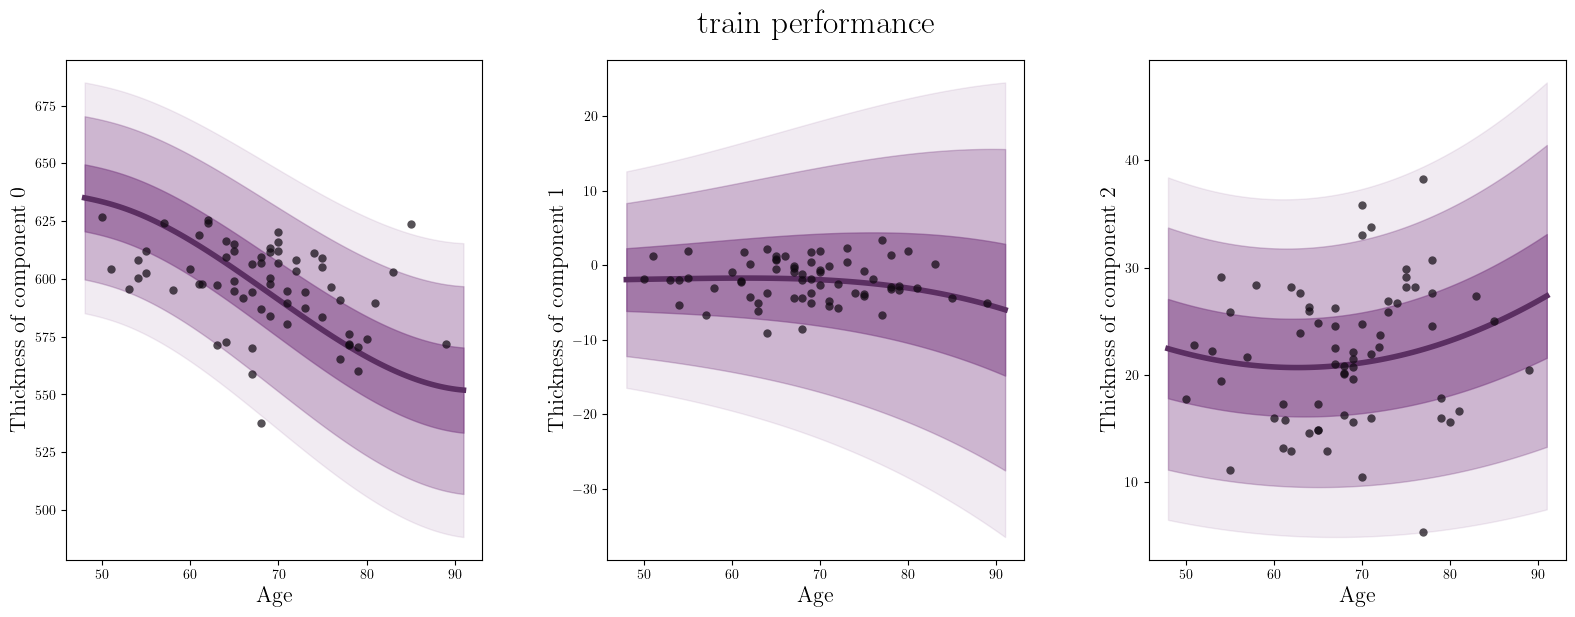

In [110]:
%%time

# sample from required columns
sample_df = train_df.copy()

# Data preperation
age = sample_df['age'].values
# age_standardized = (age - age.mean()) / age.std()
site_idxs, sites = pd.factorize(train_df['sex']*0)
sex_idxs, sexes = pd.factorize(sample_df['sex'])
# adjust for the original model flipping
sex_idxs, sexes = (1 - sex_idxs), (1 - sexes)

# Splines to model nonlinear age effects on thickness
# number of spline nuts (could be tuned)
# num_knots = 3
# knot_list = np.quantile(age_standardized, np.linspace(0, 1, num_knots))
# create b spline basis for regression using patsy
B_spline_age = patsy.build_design_matrices(
    [fixed_B_spline_age.design_info],
    {"xi": age, "knots": patsy_knots}
)[0]

coords = {
    "site": sites,
    "sex": sexes,
    "splines": np.arange(B_spline_age.shape[1]),
    "obs_id": np.arange(len(site_idxs)),
}


fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for c in range(3):
    ax = axes[c]
    kernel_name = f'thickness_connectome_pc_{c}'
    thickness = sample_df[kernel_name].values
    thickness_mean = kernel_means[c]
    thickness_std = kernel_stds[c]
    thickness_standardized = (thickness - thickness_mean) / thickness_std

    # only one site: MACC
    idx = 0
    
    sns.scatterplot(
        data=sample_df,
        x='age',
        y=kernel_name,
        ax=ax,
        linewidth=0,
        alpha = 0.7,
        color = np.array(mpl.cm.Set1(idx+3)[:3])*0.1,
        zorder = 20,
    )

    ax.set_xlabel('Age', fontsize=16)
    ax.set_ylabel(f'Thickness of component {c}', fontsize=16)

    # for idx in np.unique(site_idxs):
    # only one site: MACC
    xi = xr.DataArray(np.linspace(np.min(age) - 2, np.max(age) + 2, 100), dims=["obs_id"])
    selection = (xi > 0)
    # post = advi_model_idata.posterior
    advi_model_idata = az.from_netcdf(f'{main_dir}/Normative_Modeling/data/models/pymc/MACC_tuned_connectome_rw_kernel/{kernel_name}_pymc_advi_MACC.nc')
    post = advi_model_idata.posterior

    # prediction_B_spline_age = patsy.dmatrix(
    #     "bs(xi, knots=knots, degree=3, include_intercept=True) - 1",
    #     {"xi": ((xi - age.mean()) / age.std()), "knots": knot_list[1:-1]},
    # )
    prediction_B_spline_age = patsy.build_design_matrices(
        [fixed_B_spline_age.design_info],
        {"xi": xi, "knots": patsy_knots}
    )[0]

    # y_ppc_mu = (
    #     post['intercept_sex'].stack(sample=("chain", "draw"))[0].data +
    #     post['intercept_site'].stack(sample=("chain", "draw"))[idx].data +
    #     np.dot(
    #         prediction_B_spline_age,
    #         post['w_age'].stack(sample=("chain", "draw"))
    #     )
    # )
    # y_ppc_mu_mean = y_ppc_mu.mean(1)

    y_ppc_mu_mean = (
        np.array(kernel_posterior_means['intercept_sex'][c]).mean() +
        post['intercept_site'].stack(sample=("chain", "draw"))[idx].mean().data +
        np.dot(
            prediction_B_spline_age,
            np.array(kernel_posterior_means['w_age'][c])
        )
    )

    # y_ppc_sigma = (
    #     post['error_sex'].stack(sample=("chain", "draw"))[0].data +
    #     post['error_site'].stack(sample=("chain", "draw"))[idx].data +
    #     np.dot(
    #         prediction_B_spline_age,
    #         post['w_error_age'].stack(sample=("chain", "draw"))
    #     )
    # )
    # y_ppc_sigma_mean = y_ppc_sigma.mean(1)

    y_ppc_sigma_mean = (
        np.array(kernel_posterior_means['error_sex'][c]).mean() +
        post['error_site'].stack(sample=("chain", "draw"))[idx].mean().data +
        np.dot(
            prediction_B_spline_age,
            np.array(kernel_posterior_means['w_error_age'][c])
        )
    )

    # y_ppc_alpha = post['thickness_skewness'].stack(sample=("chain", "draw")).data

    # need to ensure the correctness
    quantiles = [0.01, 0.05, 0.25, 0.50, 0.75, 0.95, 0.99]

    thickness_quantiles = {
        q: (
            (
                y_ppc_mu_mean + stats.norm.ppf(q=q) * y_ppc_sigma_mean
                # np.quantile(((y_ppc_mu + stats.norm.ppf(q=q) * y_ppc_sigma)), q, 1)
            )  * thickness_std +
            thickness_mean
        ) for q in quantiles
    }

    # centile plot
    for q1, q2, alpha in [(0.01, 0.99, 0.1), (0.05, 0.95, 0.3), (0.25, 0.75, 0.5)]:
        ax.fill_between(
            xi[selection],
            thickness_quantiles[q1][selection],
            thickness_quantiles[q2][selection],
            alpha=alpha,
            color=np.array(mpl.cm.Set1(idx+3)[:3])*0.8,
        )

    ax.plot(
        xi[selection],
        thickness_quantiles[0.5][selection],
        c=np.array(mpl.cm.Set1(idx+3)[:3])*0.6,
        lw=4,
    )

plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.3, hspace=0.)
plt.suptitle("train performance", y=1.1, fontsize=24)

### Fine-tune normative models for covariance pairs (MACC)

---


In [127]:
import aesara.tensor as at

# random seed for reproducibility
rng = np.random.default_rng(12345)

def fine_tune_pymc_advi_covariance_on_kernel_pairs_for_MACC(pair_idx, multiplicity=1000, train_df=train_df, fixed_B_spline_age=fixed_B_spline_age):
    kernel_idx1, kernel_idx2 = selected_pairs[pair_idx]
    kernel_name1 = f'thickness_connectome_pc_{kernel_idx1}'
    kernel_name2 = f'thickness_connectome_pc_{kernel_idx2}'
    
    stored_model_file = f'{main_dir}/Normative_Modeling/data/models/pymc/MACC_tuned_connectome_rw_kernel_rho/{kernel_name1},{kernel_name2}_pymc_advi_rho_MACC.nc'
    if file_exists(stored_model_file, path_name=''):
        try:
            advi_model_idata_cov = az.from_netcdf(stored_model_file)
            if type(advi_model_idata_cov) == az.data.inference_data.InferenceData:
                return ((kernel_name1, kernel_name2), stored_model_file)
            else:
                os.remove(stored_model_file)
        except:
            os.remove(stored_model_file)
            
    
    # sample from required columns
    sample_df = train_df[['age', 'sex', kernel_name1, kernel_name2]].copy()

    # Data preperation
    age = sample_df['age'].values
    # age_standardized = (age - age.mean()) / age.std()
    thickness_v1 = sample_df[kernel_name1].values
    thickness_v1_standardized = (thickness_v1 - kernel_means[kernel_idx1]) / kernel_stds[kernel_idx1]
    thickness_v2 = sample_df[kernel_name2].values
    thickness_v2_standardized = (thickness_v2 - kernel_means[kernel_idx2]) / kernel_stds[kernel_idx2]
    thicknesses_standardized = np.concatenate([thickness_v1_standardized[:, np.newaxis], thickness_v2_standardized[:, np.newaxis]], axis=1)

    # dummy site variable of only one dimension
    site_idxs, sites = pd.factorize(train_df['sex']*0)

    # sex variable
    sex_idxs, sexes = pd.factorize(sample_df['sex'])
    # adjust for the original model flipping
    sex_idxs, sexes = (1 - sex_idxs), (1 - sexes)

    # multiple weights from the same pair
    age_mult = np.repeat(age[np.newaxis,:], multiplicity, axis=0).reshape(-1)
    sex_idxs_mult = np.repeat(sex_idxs[np.newaxis,:], multiplicity, axis=0).reshape(-1)
    site_idxs_mult = np.repeat(site_idxs[np.newaxis,:], multiplicity, axis=0).reshape(-1)

    combination_weights_mult = []
    combined_thicknesses_mult = []
    for i in range(multiplicity):
        # a weight to combine two variables with
        combination_weights = (4*(np.random.uniform(size=thicknesses_standardized.shape) - 0.5))
        combination_weights_mult.append(combination_weights)

        # combine values
        combined_thicknesses = np.multiply(thicknesses_standardized, combination_weights).sum(1)
        combined_thicknesses_mult.append(combined_thicknesses)

    combination_weights_mult = np.concatenate(combination_weights_mult)
    combined_thicknesses_mult = np.concatenate(combined_thicknesses_mult)

    # Splines to model nonlinear age effects on thickness
    # Using the fixed B-Spline, no need to standardize age range
    B_spline_age = patsy.build_design_matrices(
        [fixed_B_spline_age.design_info],
        {"xi": age_mult, "knots": patsy_knots}
    )[0]

    coords = {
        "site": sites,
        "sex": sexes,
        "splines": np.arange(B_spline_age.shape[1]),
        "obs_id": np.arange(len(site_idxs_mult)),
    }

    # loading previously fitted priors to use as constants
    advi_model_idata_v1 = az.from_netcdf(f'{main_dir}/Normative_Modeling/data/models/pymc/MACC_tuned_connectome_rw_kernel/{kernel_name1}_pymc_advi_MACC.nc')
    advi_model_idata_v2 = az.from_netcdf(f'{main_dir}/Normative_Modeling/data/models/pymc/MACC_tuned_connectome_rw_kernel/{kernel_name2}_pymc_advi_MACC.nc')

    kernel_advi_model_cov = pm.Model(coords=coords)

    # a nonlinear spline model (see https://www.pymc.io/projects/examples/en/latest/case_studies/spline.html)
    with kernel_advi_model_cov:
        # minibatch variables
        # age_t = pm.Minibatch(age_mult, 512,)
        sex_idx_t = pm.Minibatch(sex_idxs_mult, 128)
        site_idx_t = pm.Minibatch(site_idxs_mult, 128)
        B_spline_age_t = pm.Minibatch(B_spline_age, 128)
        combined_thicknesses_t = pm.Minibatch(combined_thicknesses_mult, 128)
        combination_weights_t = pm.Minibatch(combination_weights_mult, 128)

        # pretrainted Hyperpriors for site groups (as if we have random group effects)
        # mu_intercept_site_rho = pm.Normal('mu_intercept_site_rho', mu=0, sigma=10)
        mu_intercept_site_rho = pm.ConstantData("mu_intercept_site_rho", np.array(rho_kernel_posterior_means['mu_intercept_site_rho'][kernel_idx]))
        # sigma_intercept_site_rho = pm.HalfNormal("sigma_intercept_site_rho", sigma=10)
        sigma_intercept_site_rho = pm.ConstantData("sigma_intercept_site_rho", np.array(rho_kernel_posterior_means['sigma_intercept_site_rho'][kernel_idx]))
        # sigma_error_site_cov = pm.HalfNormal("sigma_error_site_cov", sigma=10)


        # Priors (for covariance/correlation)
        # pretrained sex effects (similar to fixed sex effects (intercept only))
        # intercept_sex_rho = pm.Normal("intercept_sex_rho", mu=0, sigma=0.1, dims="sex")
        intercept_sex_rho = pm.ConstantData("intercept_sex_rho", np.array(rho_kernel_posterior_means['intercept_sex_rho'][kernel_idx]), dims="sex")

        # site effects (similar to random site effects (intercept only))
        intercept_site_offset_rho = pm.Normal("intercept_site_offset_rho", mu=0, sigma=0.1, dims="site")
        intercept_site_rho = pm.Deterministic("intercept_site_rho", mu_intercept_site_rho + intercept_site_offset_rho * sigma_intercept_site_rho, dims="site")

        # pretrained age splines
        # w_age_rho = pm.Normal("w_age_rho", mu=0, sigma=0.1, size=B_spline_age.shape[1], dims="splines")
        w_age_rho = pm.ConstantData("w_age_rho", np.array(rho_kernel_posterior_means['w_age_rho'][kernel_idx]), dims="splines")

        # Estimated covariance/correlation
        # z_est = pm.Deterministic("z_est", intercept_sex_rho[sex_idx_t] + intercept_site_rho[site_idx_t] + pm.math.dot(B_spline_age_t, w_age_rho.T), dims="obs_id")
        z_est = intercept_sex_rho[sex_idx_t] + intercept_site_rho[site_idx_t] + pm.math.dot(B_spline_age_t, w_age_rho.T)
        # rho_est = pm.Deterministic("rho_est", 2 * pm.math.sigmoid(intercept_sex_rho[sex_idx_t] + intercept_site_rho[site_idx_t] + pm.math.dot(B_spline_age_t, w_age_rho.T)) - 1)
        # rho_est = pm.Deterministic("rho_est", 2 * pm.math.sigmoid(z_est) - 1)
        rho_est = 2 * pm.math.sigmoid(z_est) - 1
    

        # Priors (constant priors, already fitted in previous models)
        # pretrained sex effects (similar to fixed sex effects (intercept only))
        # intercept_sex = pm.Normal("intercept_sex", mu=0, sigma=10, dims="sex")
        # intercept_sex_v1 = pm.ConstantData("intercept_sex_v1", np.array(advi_model_idata_v1.posterior['intercept_sex'].stack(sample=("chain", "draw")).mean('sample')), dims="sex")
        intercept_sex_v1 = pm.ConstantData("intercept_sex_v1", np.array(kernel_posterior_means['intercept_sex'][kernel_idx1]), dims="sex")
        # intercept_sex_v2 = pm.ConstantData("intercept_sex_v2", np.array(advi_model_idata_v2.posterior['intercept_sex'].stack(sample=("chain", "draw")).mean('sample')), dims="sex")
        intercept_sex_v2 = pm.ConstantData("intercept_sex_v2", np.array(kernel_posterior_means['intercept_sex'][kernel_idx2]), dims="sex")
    
        # site effects (similar to random site effects (intercept only))
        #a_site = pm.Normal("a_site", mu=mu_a_site, sigma=sigma_a_site, dims="site")
        # intercept_site_offset = pm.Normal("intercept_site_offset", mu=0, sigma=1, dims="site")
        # intercept_site = pm.Deterministic("intercept_site", mu_intercept_site + intercept_site_offset * sigma_intercept_site, dims="site")
        intercept_site_v1 = pm.ConstantData("intercept_site_v1", np.array(advi_model_idata_v1.posterior['intercept_site'].stack(sample=("chain", "draw")).mean('sample')), dims="site")
        intercept_site_v2 = pm.ConstantData("intercept_site_v2", np.array(advi_model_idata_v2.posterior['intercept_site'].stack(sample=("chain", "draw")).mean('sample')), dims="site")

        # age splines
        # w_age = pm.Normal("w_age", mu=0, sigma=10, size=B_spline_age.shape[1], dims="splines")
        # w_age_v1 = pm.ConstantData("w_age_v1", np.array(advi_model_idata_v1.posterior['w_age'].stack(sample=("chain", "draw")).mean('sample')), dims="splines")
        w_age_v1 = pm.ConstantData("w_age_v1", np.array(kernel_posterior_means['w_age'][kernel_idx1]), dims="splines")
        # w_age_v2 = pm.ConstantData("w_age_v2", np.array(advi_model_idata_v2.posterior['w_age'].stack(sample=("chain", "draw")).mean('sample')), dims="splines")
        w_age_v2 = pm.ConstantData("w_age_v2", np.array(kernel_posterior_means['w_age'][kernel_idx2]), dims="splines")

        # Estimated thickness
        # thickness_est = pm.Deterministic("thickness_est", intercept_sex[sex_idx_t] + intercept_site[site_idx_t] + pm.math.dot(B_spline_age_t, w_age.T))
        # thickness_est_v1 = pm.Deterministic("thickness_est_v1", intercept_sex_v1[sex_idx_t] + intercept_site_v1[site_idx_t] + pm.math.dot(B_spline_age_t, w_age_v1.T))
        thickness_est_v1 = intercept_sex_v1[sex_idx_t] + intercept_site_v1[site_idx_t] + pm.math.dot(B_spline_age_t, w_age_v1.T)
        # thickness_est_v2 = pm.Deterministic("thickness_est_v2", intercept_sex_v2[sex_idx_t] + intercept_site_v2[site_idx_t] + pm.math.dot(B_spline_age_t, w_age_v2.T))
        thickness_est_v2 = intercept_sex_v2[sex_idx_t] + intercept_site_v2[site_idx_t] + pm.math.dot(B_spline_age_t, w_age_v2.T)

        # Model error
        # nonlinear age error
        # w_error_age = pm.HalfCauchy("w_error_age", beta=5, size=B_spline_age.shape[1], dims="splines")
        # w_error_age_v1 = pm.ConstantData("w_error_age_v1", np.array(advi_model_idata_v1.posterior['w_error_age'].stack(sample=("chain", "draw")).mean('sample')), dims="splines")
        w_error_age_v1 = pm.ConstantData("w_error_age_v1", np.array(kernel_posterior_means['w_error_age'][kernel_idx1]), dims="splines")
        # w_error_age_v2 = pm.ConstantData("w_error_age_v2", np.array(advi_model_idata_v2.posterior['w_error_age'].stack(sample=("chain", "draw")).mean('sample')), dims="splines")
        w_error_age_v2 = pm.ConstantData("w_error_age_v2", np.array(kernel_posterior_means['w_error_age'][kernel_idx2]), dims="splines")

        # constant sex error
        # error_sex = pm.HalfCauchy("error_sex", beta=5, dims="sex")
        # error_sex_v1 = pm.ConstantData("error_sex_v1", np.array(advi_model_idata_v1.posterior['error_sex'].stack(sample=("chain", "draw")).mean('sample')), dims="sex")
        error_sex_v1 = pm.ConstantData("error_sex_v1", np.array(kernel_posterior_means['error_sex'][kernel_idx1]), dims="sex")
        # error_sex_v2 = pm.ConstantData("error_sex_v2", np.array(advi_model_idata_v2.posterior['error_sex'].stack(sample=("chain", "draw")).mean('sample')), dims="sex")
        error_sex_v2 = pm.ConstantData("error_sex_v2", np.array(kernel_posterior_means['error_sex'][kernel_idx2]), dims="sex")

        # random site error
        # error_site_offset = pm.HalfCauchy("error_site_offset", beta=5, dims="site")
        # error_site = pm.Deterministic("error_site", error_site_offset * sigma_error_site, dims="site")
        error_site_v1 = pm.ConstantData("error_site_v1", np.array(advi_model_idata_v1.posterior['error_site'].stack(sample=("chain", "draw")).mean('sample')), dims="site")
        error_site_v2 = pm.ConstantData("error_site_v2", np.array(advi_model_idata_v2.posterior['error_site'].stack(sample=("chain", "draw")).mean('sample')), dims="site")

        # Error estimate
        # thickness_error = pm.Deterministic("thickness_error", error_sex[sex_idx_t] + error_site[site_idx_t] + pm.math.dot(B_spline_age_t, w_error_age.T))
        # thickness_error_v1 = pm.Deterministic("thickness_error_v1", error_sex_v1[sex_idx_t] + error_site_v1[site_idx_t] + pm.math.dot(B_spline_age_t, w_error_age_v1.T))
        thickness_error_v1 = error_sex_v1[sex_idx_t] + error_site_v1[site_idx_t] + pm.math.dot(B_spline_age_t, w_error_age_v1.T)
        # thickness_error_v2 = pm.Deterministic("thickness_error_v2", error_sex_v2[sex_idx_t] + error_site_v2[site_idx_t] + pm.math.dot(B_spline_age_t, w_error_age_v2.T))
        thickness_error_v2 = error_sex_v2[sex_idx_t] + error_site_v2[site_idx_t] + pm.math.dot(B_spline_age_t, w_error_age_v2.T)

        # Likelihood (sampling distribution) of observations
        # Likelihood estimation from a bivariate normal with known mean and variance, but unknown covariance
        # combined_mu = pm.Deterministic("combined_mu", pm.math.sum(at.math.mul(combination_weights_t, at.stacklists([thickness_est_v1, thickness_est_v2]).T), axis=1))
        combined_mu = pm.math.sum(at.math.mul(combination_weights_t, at.stacklists([thickness_est_v1, thickness_est_v2]).T), axis=1)
        # combined_sigma = pm.Deterministic("combined_sigma", at.math.mul(combination_weights_t, at.stacklists([thickness_error_v1, thickness_error_v2]).T))
        combined_sigma = at.math.mul(combination_weights_t, at.stacklists([thickness_error_v1, thickness_error_v2]).T)
        # combined_var = pm.Deterministic("combined_var", pm.math.sqrt(combined_sigma[:, 0]**2 + combined_sigma[:, 1]**2 + 2 * combined_sigma[:, 0] * combined_sigma[:, 1] * rho_est))
        combined_var = pm.math.sqrt(combined_sigma[:, 0]**2 + combined_sigma[:, 1]**2 + 2 * combined_sigma[:, 0] * combined_sigma[:, 1] * rho_est)
    
        # Likelihood estimation for covariance
        likelihood = pm.Normal(
            "likelihood",
            mu=combined_mu,
            sigma=combined_var,
            observed=combined_thicknesses_t,
            total_size=len(sample_df) * multiplicity,
        )

        # run ADVI with minibatch
        error_approx_cov = pm.fit(100000, callbacks=[pm.callbacks.CheckParametersConvergence(tolerance=1e-4)], random_seed=12345)
    
        # sample from trace
        advi_model_idata_cov = pm.sample_prior_predictive(random_seed=rng)
        advi_model_idata_cov.extend(error_approx_cov.sample(2000, random_seed=rng))
        pm.sample_posterior_predictive(advi_model_idata_cov, extend_inferencedata=True, random_seed=rng)
    
    advi_model_idata_cov.to_netcdf(ensure_dir(stored_model_file))
    return ((kernel_name1, kernel_name2), stored_model_file)

        

In [128]:
%%time

pair_idx = 0
kernel_idx1, kernel_idx2 = selected_pairs[pair_idx]
kernel_name1 = f'thickness_connectome_pc_{kernel_idx1}'
kernel_name2 = f'thickness_connectome_pc_{kernel_idx2}'
fine_tune_pymc_advi_covariance_on_kernel_pairs_for_MACC(pair_idx)


Convergence achieved at 79900
Interrupted at 79,899 [79%]: Average Loss = 154.14
Sampling: [intercept_site_offset_rho, likelihood]
/home/sina/storage/miniconda/envs/normative_env/lib/python3.10/site-packages/pymc/backends/arviz.py:56: UserWarning: Could not extract data from symbolic observation likelihood
  warnings.warn(f"Could not extract data from symbolic observation {obs}")
/home/sina/storage/miniconda/envs/normative_env/lib/python3.10/site-packages/pymc/backends/arviz.py:56: UserWarning: Could not extract data from symbolic observation likelihood
  warnings.warn(f"Could not extract data from symbolic observation {obs}")
Sampling: [likelihood]


/home/sina/storage/miniconda/envs/normative_env/lib/python3.10/site-packages/pymc/backends/arviz.py:56: UserWarning: Could not extract data from symbolic observation likelihood
  warnings.warn(f"Could not extract data from symbolic observation {obs}")


CPU times: user 50.5 s, sys: 1.3 s, total: 51.8 s
Wall time: 1min 34s


(('thickness_connectome_pc_0', 'thickness_connectome_pc_1'),
 '/home/sina/storage/Normative_Modeling/data/models/pymc/MACC_tuned_connectome_rw_kernel_rho/thickness_connectome_pc_0,thickness_connectome_pc_1_pymc_advi_rho_MACC.nc')

In [136]:
f'{main_dir}/Normative_Modeling/data/models/pymc/MACC_tuned_connectome_rw_kernel_rho/{kernel_name1},{kernel_name2}_pymc_advi_rho_MACC.nc'

'/home/sina/storage/Normative_Modeling/data/models/pymc/MACC_tuned_connectome_rw_kernel_rho/thickness_connectome_pc_0,thickness_connectome_pc_1_pymc_advi_rho_MACC.nc'

In [135]:
# mask pairs including higher order eigenmodes
selected_pair_mask = (selected_pairs<N_kernels).all(1)
selected_pairs_N_kernels_masked = selected_pairs[selected_pair_mask]


In [141]:
%%time
%%capture multiprocessing_log

import multiprocessing
import time

def mute():
    sys.stdout = open(os.devnull, 'w')

PROCESSES = 16
with multiprocessing.Pool(PROCESSES, initializer=mute) as pool:
    collected_results = pool.map(
        fine_tune_pymc_advi_covariance_on_kernel_pairs_for_MACC,
        [x for x in np.where(selected_pair_mask)[0]]
    )


Convergence achieved at 31400
Interrupted at 31,399 [31%]: Average Loss = 182.89
Sampling: [intercept_site_offset_rho, likelihood]
Convergence achieved at 43400
Interrupted at 43,399 [43%]: Average Loss = 173.33
Sampling: [likelihood]
Sampling: [intercept_site_offset_rho, likelihood]
Convergence achieved at 48600
Interrupted at 48,599 [48%]: Average Loss = 241.15
Sampling: [likelihood]
Sampling: [intercept_site_offset_rho, likelihood]
Convergence achieved at 56700
Interrupted at 56,699 [56%]: Average Loss = 183.48
Convergence achieved at 57800
Interrupted at 57,799 [57%]: Average Loss = 173.07
Sampling: [intercept_site_offset_rho, likelihood]
Convergence achieved at 59200
Interrupted at 59,199 [59%]: Average Loss = 185.43
Sampling: [intercept_site_offset_rho, likelihood]
Sampling: [intercept_site_offset_rho, likelihood]
Sampling: [likelihood]
Convergence achieved at 62700
Interrupted at 62,699 [62%]: Average Loss = 162.07
Sampling: [intercept_site_offset_rho, likelihood]
Sampling: [lik

CPU times: user 6.18 s, sys: 6.47 s, total: 12.6 s
Wall time: 1h 53min 57s


### Export fine-tuned site parameters

---


In [143]:
%%time
# Load all posterior distributions of fine-tuned models
kernel_idata = {}

# for i in tqdm(range(all_thickness_data_encoded.shape[1])):
for i in tqdm(range(N_kernels)):
    kernel_name = f'thickness_connectome_pc_{i}'
    kernel_idata[kernel_name] = az.from_netcdf(f'{main_dir}/Normative_Modeling/data/models/pymc/MACC_tuned_connectome_rw_kernel/{kernel_name}_pymc_advi_MACC.nc')


  0%|          | 0/1000 [00:00<?, ?it/s]

CPU times: user 3min 13s, sys: 8.57 s, total: 3min 22s
Wall time: 4min 30s


In [144]:
%%time
# concatenate posteriors along a new dimension
# kernel_posteriors = xr.concat([kernel_idata[f'thickness_connectome_pc_{i}'].posterior for i in range(all_thickness_data_encoded.shape[1])], "kernel")
kernel_posteriors_MACC = xr.concat([kernel_idata[f'thickness_connectome_pc_{i}'].posterior for i in range(N_kernels)], "kernel")
kernel_posteriors_MACC


CPU times: user 58.1 s, sys: 4.49 s, total: 1min 2s
Wall time: 1min 29s


<xarray.Dataset> Size: 64MB
Dimensions:                (kernel: 1000, chain: 1, draw: 2000, site: 1)
Coordinates:
  * chain                  (chain) int64 8B 0
  * draw                   (draw) int64 16kB 0 1 2 3 4 ... 1996 1997 1998 1999
  * site                   (site) int64 8B 0
Dimensions without coordinates: kernel
Data variables:
    error_site             (kernel, chain, draw, site) float64 16MB 0.0203 .....
    error_site_offset      (kernel, chain, draw, site) float64 16MB 0.5716 .....
    intercept_site         (kernel, chain, draw, site) float64 16MB -0.1985 ....
    intercept_site_offset  (kernel, chain, draw, site) float64 16MB -0.306 .....
Attributes:
    created_at:                 2024-08-14T06:13:38.954923+00:00
    arviz_version:              0.19.0
    inference_library:          pymc
    inference_library_version:  4.2.2

In [145]:
%%time
kernel_posteriors_MACC.to_netcdf(f'{main_dir}/Normative_Modeling/data/models/pymc/MACC_tuned_combined_connectome_rw_kernel_posteriors_pymc_advi.nc')


CPU times: user 99.6 ms, sys: 172 ms, total: 271 ms
Wall time: 766 ms


In [146]:
%%time
kernel_posterior_means_MACC = kernel_posteriors_MACC.mean(dim=["chain", "draw"])
kernel_posterior_means_MACC


CPU times: user 45.5 ms, sys: 5.1 ms, total: 50.6 ms
Wall time: 48 ms


<xarray.Dataset> Size: 32kB
Dimensions:                (kernel: 1000, site: 1)
Coordinates:
  * site                   (site) int64 8B 0
Dimensions without coordinates: kernel
Data variables:
    error_site             (kernel, site) float64 8kB 0.03339 0.02879 ... 0.195
    error_site_offset      (kernel, site) float64 8kB 0.9403 0.07786 ... 1.193
    intercept_site         (kernel, site) float64 8kB -0.1361 ... -0.009912
    intercept_site_offset  (kernel, site) float64 8kB -0.2087 ... -0.6289

In [147]:
%%time
kernel_posterior_means_MACC.to_netcdf(f'{main_dir}/Normative_Modeling/data/models/pymc/MACC_tuned_combined_connectome_rw_kernel_posterior_means_pymc_advi.nc')


CPU times: user 6.96 ms, sys: 787 μs, total: 7.74 ms
Wall time: 10.7 ms


In [165]:
%%time

rho_kernel_idata = {}

for i in tqdm(np.where(selected_pair_mask)[0]):
    kernel_idx1, kernel_idx2 = selected_pairs[i]
    kernel_name1, kernel_name2 = f'thickness_connectome_pc_{kernel_idx1}', f'thickness_connectome_pc_{kernel_idx2}'
    rho_kernel_idata[(kernel_name1, kernel_name2)] = az.from_netcdf(f'{main_dir}/Normative_Modeling/data/models/pymc/MACC_tuned_connectome_rw_kernel_rho/{kernel_name1},{kernel_name2}_pymc_advi_rho_MACC.nc')


  0%|          | 0/1976 [00:00<?, ?it/s]

CPU times: user 7min 21s, sys: 15.1 s, total: 7min 36s
Wall time: 11min 12s


In [166]:
%%time
# concatenate posteriors along a new dimension
rho_kernel_posteriors_MACC = xr.concat(
    [
        rho_kernel_idata[(f'thickness_connectome_pc_{selected_pairs[i][0]}', f'thickness_connectome_pc_{selected_pairs[i][1]}')].posterior for i in np.where(selected_pair_mask)[0]
    ], "kernel_pair"
)
rho_kernel_posteriors_MACC


CPU times: user 55 s, sys: 4.53 s, total: 59.6 s
Wall time: 1min 24s


<xarray.Dataset> Size: 63MB
Dimensions:                    (kernel_pair: 1976, chain: 1, draw: 2000, site: 1)
Coordinates:
  * chain                      (chain) int64 8B 0
  * draw                       (draw) int64 16kB 0 1 2 3 ... 1996 1997 1998 1999
  * site                       (site) int64 8B 0
Dimensions without coordinates: kernel_pair
Data variables:
    intercept_site_offset_rho  (kernel_pair, chain, draw, site) float64 32MB ...
    intercept_site_rho         (kernel_pair, chain, draw, site) float64 32MB ...
Attributes:
    created_at:                 2024-08-14T09:03:59.395645+00:00
    arviz_version:              0.19.0
    inference_library:          pymc
    inference_library_version:  4.2.2

In [167]:
%%time
rho_kernel_posteriors_MACC.to_netcdf(f'{main_dir}/Normative_Modeling/data/models/pymc/MACC_tuned_combined_connectome_rw_rho_kernel_posteriors_pymc_advi.nc')


CPU times: user 52.1 ms, sys: 152 ms, total: 204 ms
Wall time: 278 ms


In [168]:
%%time
rho_kernel_posterior_means_MACC = rho_kernel_posteriors_MACC.mean(dim=["chain", "draw"])
rho_kernel_posterior_means_MACC


CPU times: user 41.1 ms, sys: 9.14 ms, total: 50.3 ms
Wall time: 47.6 ms


<xarray.Dataset> Size: 32kB
Dimensions:                    (kernel_pair: 1976, site: 1)
Coordinates:
  * site                       (site) int64 8B 0
Dimensions without coordinates: kernel_pair
Data variables:
    intercept_site_offset_rho  (kernel_pair, site) float64 16kB -0.5181 ... -...
    intercept_site_rho         (kernel_pair, site) float64 16kB 0.3044 ... 0....

In [170]:
%%time
rho_kernel_posterior_means_MACC.to_netcdf(f'{main_dir}/Normative_Modeling/data/models/pymc/MACC_tuned_combined_connectome_rw_rho_kernel_posterior_means_pymc_advi.nc')


CPU times: user 4.21 ms, sys: 4.09 ms, total: 8.3 ms
Wall time: 12 ms
